In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
root_mean_squared_error = lambda y1, y2: np.sqrt(mean_squared_error(y1, y2))

from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency

In [2]:
def my_evaluation(model, start_k, X, Y):
    X_shuffled, y_shuffled = shuffle(X, Y, random_state=42)
    vals = np.arange(start_k, len(X), 10)
    metrics = [mean_absolute_error, root_mean_squared_error]
    metrics_name = ['metric MAE', 'metric RMSE']

    metric_dict = {loss_function: [] for loss_function in metrics}

    for num in tqdm(vals):
        X_train, X_test, y_train, y_test = train_test_split(X_shuffled[:num], y_shuffled[:num], test_size=0.3, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        for metric in metrics:
            loss = metric(y_test, y_pred)
            metric_dict[metric].append(loss)

    plt.figure(figsize=(20,8))
    for metric, metric_name in zip(metrics, metrics_name):
        loss = metric(y_test, y_pred)
        plt.plot(vals, np.log(metric_dict[metric]), label=metric_name)

    plt.legend()
    plt.title("Metrics")
    plt.xlabel("Sample Size")
    plt.ylabel("Losses")
    plt.show()

# Loading dataset

In [3]:
df = pd.read_csv("tslaUsedCarsInventoryDataSet.csv")
print(df.shape)
df = df.drop(columns=['emi', 'zipCode', 'state'])
categorical_columns = ['model', 'location', 'driveTrain', 'DAS', 'accident_history', 'paintJob', 'wheels', 'interior']
df.head()

(1912, 14)


,model,year,odometer,price,location,driveTrain,DAS,accident_history,paintJob,wheels,interior
0,Model S,2018.0,36438.0,53300.0,"Colma, CA",100D Long Range All-Wheel Drive,Autopilot,Previously Repaired,Red Multi-Coat Paint,"19"" Silver Slipstream Wheels",Cream Premium Interior
1,Model S,2018.0,30180.0,59200.0,"Colma, CA",100D Long Range All-Wheel Drive,Previously Repaired,30-Day Premium Connectivity Trial,Midnight Silver Metallic Paint,"21"" Sonic Carbon Twin Turbine Wheels",Black Premium Interior
2,Model S,2018.0,95696.0,36100.0,"Scottsdale, AZ",100D Long Range All-Wheel Drive,Enhanced Autopilot,No Reported Accidents/Damage,Midnight Silver Metallic Paint,"19"" Sonic Carbon Slipstream Wheels",Black Premium Interior
3,Model S,2018.0,36438.0,53300.0,"Colma, CA",100D Long Range All-Wheel Drive,Autopilot,Previously Repaired,Red Multi-Coat Paint,"19"" Silver Slipstream Wheels",Cream Premium Interior
4,Model S,2018.0,30180.0,59200.0,"Colma, CA",100D Long Range All-Wheel Drive,Previously Repaired,30-Day Premium Connectivity Trial,Midnight Silver Metallic Paint,"21"" Sonic Carbon Twin Turbine Wheels",Black Premium Interior


# Dataset Analysis

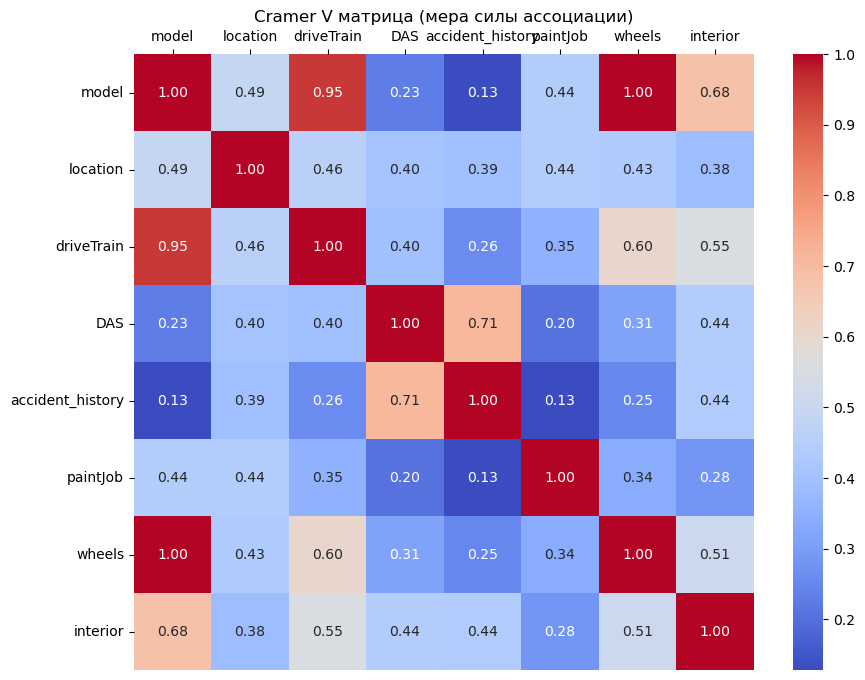

In [4]:
def cramer_v_matrix(df, categorical_columns):
    corr_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

    for col1 in categorical_columns:
        for col2 in categorical_columns:
            contingency_table = pd.crosstab(df[col1], df[col2])
            chi2, _, _, _ = chi2_contingency(contingency_table)
            n = contingency_table.values.sum()
            cramer_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
            corr_matrix.loc[col1, col2] = cramer_v
    return corr_matrix

# Пример использования
df_a = df.copy().apply(lambda x: x.fillna(x.median()) if x.dtype.kind in 'iufc' else x.fillna(x.mode().iloc[0]) if x.dtype == 'O' else x)
encoder = OrdinalEncoder()
df_a[categorical_columns] = encoder.fit_transform(df_a[categorical_columns])

theils_u_matrix =  cramer_v_matrix(df_a, categorical_columns).applymap(pd.to_numeric)

# Вывод результатов с использованием seaborn для красивого отображения
plt.figure(figsize=(10, 8))
ax = sns.heatmap(theils_u_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=categorical_columns, yticklabels=categorical_columns)
ax.xaxis.tick_top()
plt.title("Cramer V матрица (мера силы ассоциации)")
plt.show()


In [5]:
df = df.drop(columns=['driveTrain', 'wheels'])
categorical_columns = ['model', 'location', 'DAS', 'accident_history', 'paintJob', 'interior']
print(df.shape)

(1912, 9)


# Task 1:
Временно убрать категориальные признаки. Построить линейную регрессию.

In [6]:
def preprocessing_task1(data):
    # Создайте копию данных для избежания изменения оригинального датасета
    df_regression = data.copy().drop(columns=categorical_columns)
    
    # Замените NaN на среднее значение для каждой колонки
    df_regression.fillna(df_regression.mean(), inplace=True)
    
    # Инициализируйте MinMaxScaler
    scaler = MinMaxScaler()
    
    # Масштабируйте значения в каждой колонке, кроме 'price'
    for name in df_regression.columns:
        if name != 'price':
            df_regression[name] = scaler.fit_transform(df_regression[[name]])
    
    # Получите X и Y
    X = df_regression.drop('price', axis=1)
    Y = df_regression['price']
    
    return X, Y

(1912, 2)


  0%|          | 0/162 [00:00<?, ?it/s]

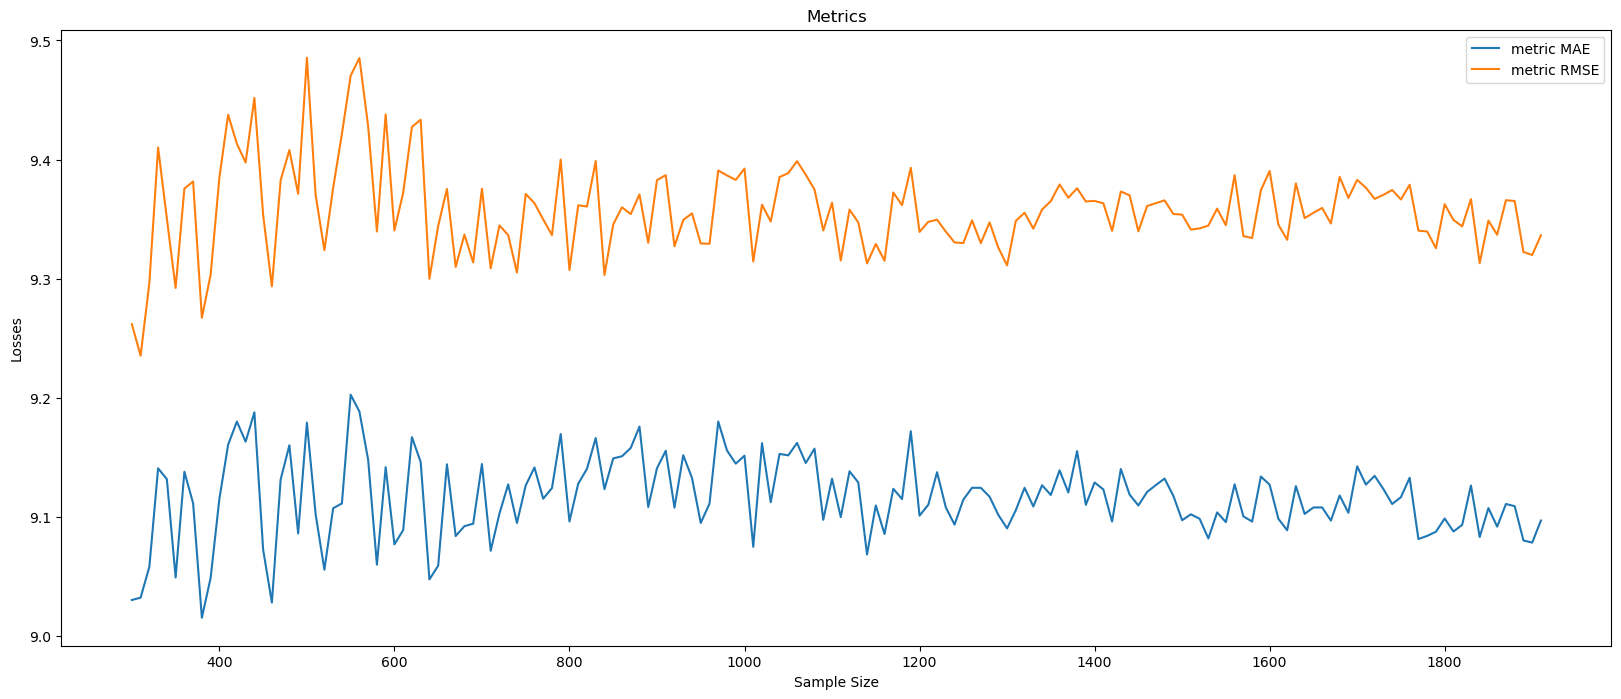

In [7]:
#Линейная регрессия
X, Y = preprocessing_task1(df)
print(X.shape)
my_evaluation(LinearRegression(), 300, X, Y)

# Task 2
Построить решение методом бустинга. Сравнить с линейной регрессией.


  0%|          | 0/162 [00:00<?, ?it/s]

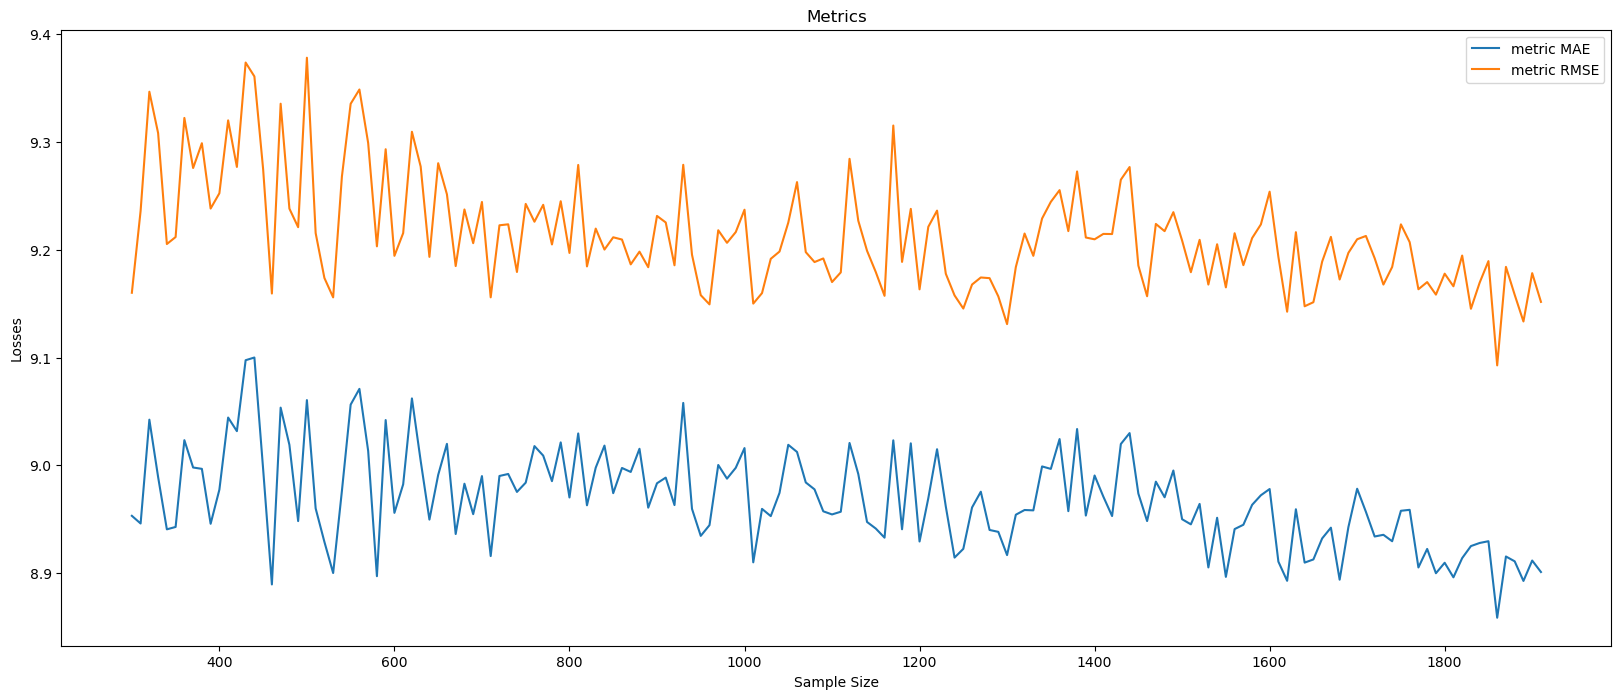

In [8]:
#CatBoost
X, Y = preprocessing_task1(df)
my_evaluation(CatBoostRegressor(iterations=200, learning_rate=0.1, depth=5, random_state=42, verbose=0), 300, X, Y)

# Task 3
Применить one hot и target encoding для категориальных признаков (взять данные, где такие признаки есть). Сравнить точность.

In [9]:
def preprocessing_task4(data):
    # Создайте копию данных для избежания изменения оригинального датасета
    full_df = data.copy()
    
    full_df = pd.get_dummies(full_df, columns=categorical_columns, prefix=categorical_columns, dtype=int)
    # Замените NaN на среднее значение для каждой колонки
    full_df.fillna(full_df.mean(), inplace=True)
    
    # Инициализируйте MinMaxScaler
    scaler = MinMaxScaler()
    
    # Масштабируйте значения в каждой колонке, кроме 'price'
    for name in full_df.columns:
        if not (name in list(categorical_columns) + ['price']):
            full_df[name] = scaler.fit_transform(full_df[[name]])
    
    # Получите X и Y
    X = full_df.drop('price', axis=1)
    Y = full_df['price']
    
    return X, Y

(1912, 117)


  0%|          | 0/162 [00:00<?, ?it/s]

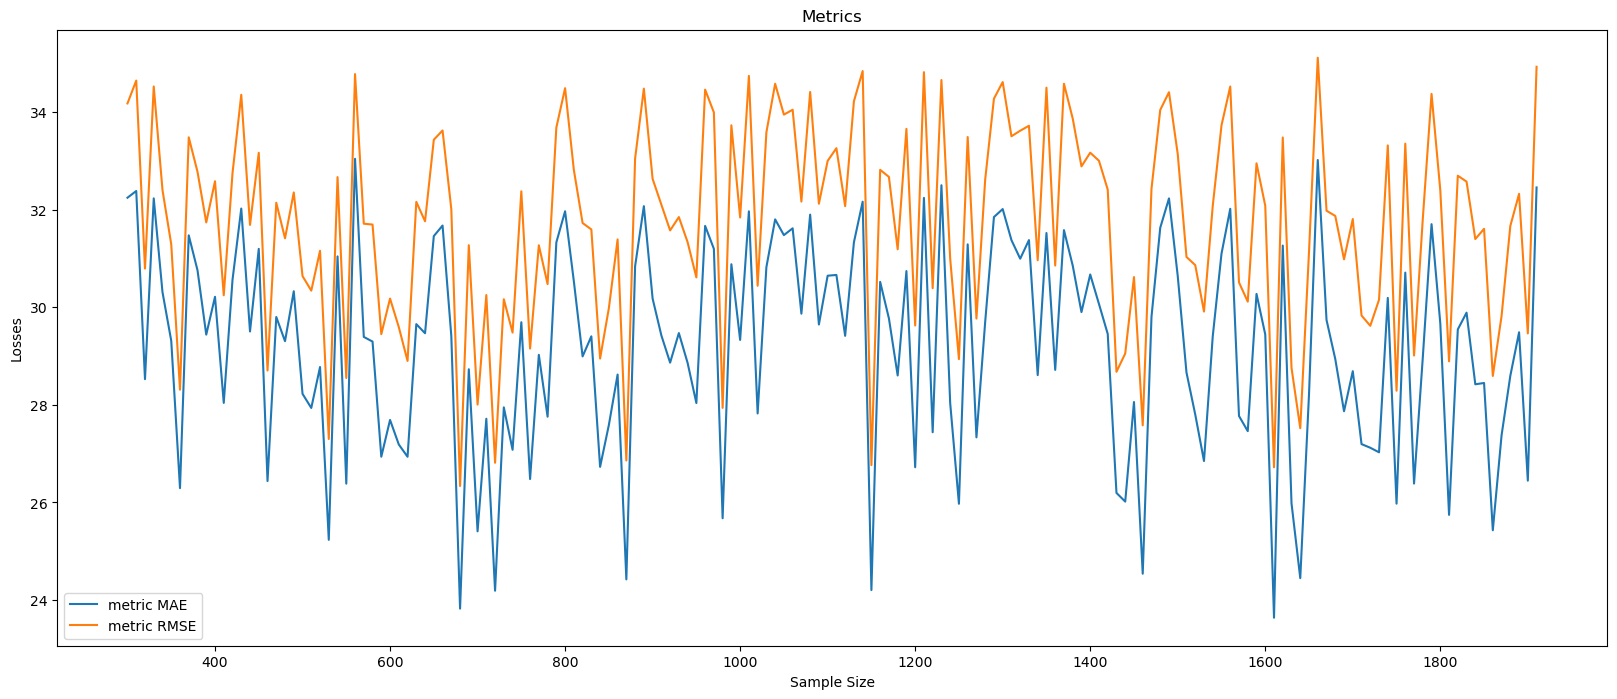

In [10]:
#Линейная регрессия
X, Y = preprocessing_task4(df)
print(X.shape)
my_evaluation(LinearRegression(), 300, X, Y)

  0%|          | 0/162 [00:00<?, ?it/s]

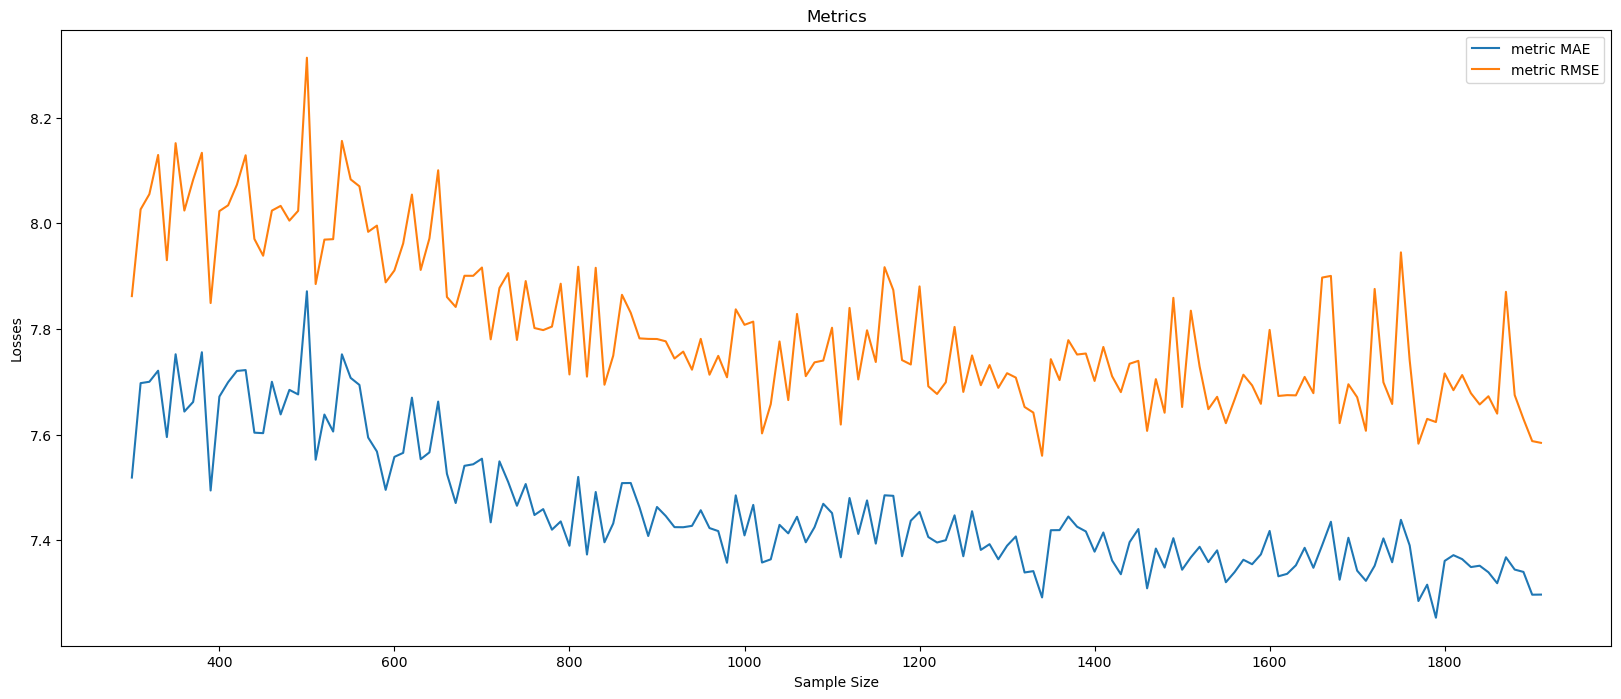

In [11]:
#CatBoost
X, Y = preprocessing_task4(df)
my_evaluation(CatBoostRegressor(iterations=200, learning_rate=0.1, depth=5, random_state=42, verbose=0), 300, X, Y)

# Task 4
Визуализировать объекты в пространстве главных компонент.

In [12]:
X, Y = preprocessing_task4(df)
# Assuming X is a DataFrame
X_array = X.values  # Convert DataFrame to NumPy array
n_features = X_array.shape[1]
# Вычисление матрицы ковариации
cov_matrix = np.cov(X_array.T)
# Вычисление собственных значений и векторов
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
# Сортировка собственных значений и выбор двух главных компонент
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)

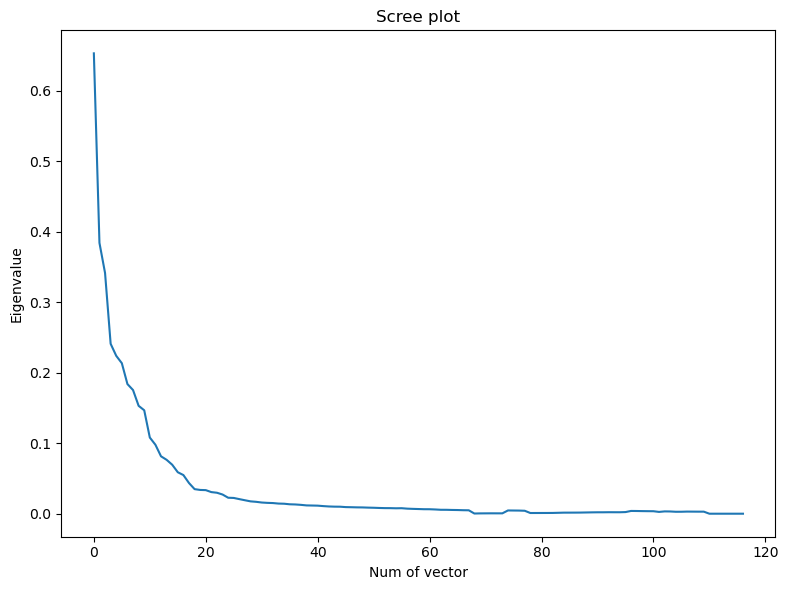

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(eig_vals)), np.real(eig_vals))
plt.ylabel('Eigenvalue')
plt.xlabel('Num of vector')
plt.title('Scree plot')
plt.tight_layout()
plt.show()

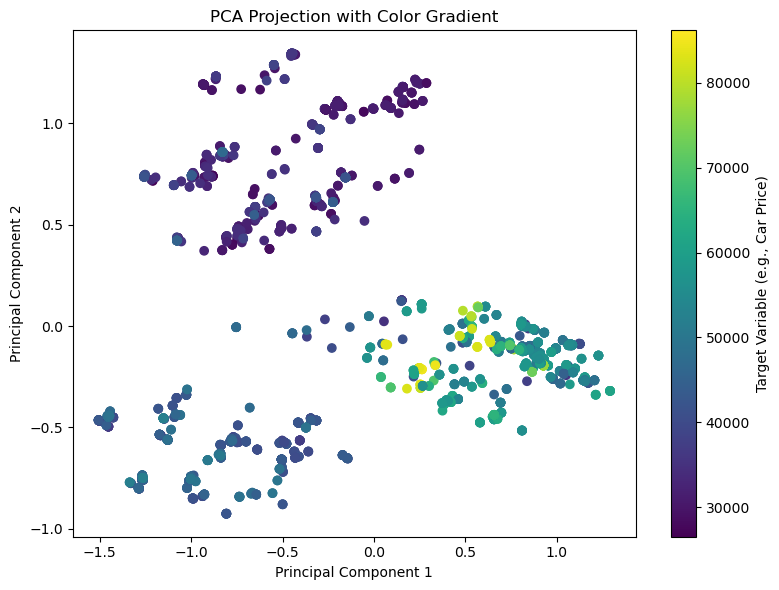

In [14]:
k = 2
matrix_w = np.hstack([eig_pairs[i][1].reshape(n_features, 1) for i in range(k)])
# Проекция данных на новое пространство признаков
X_pca = np.real(X_array.dot(matrix_w))
# Визуализация результата с градиентом цветов
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y, cmap='viridis', marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Target Variable (e.g., Car Price)')
plt.title('PCA Projection with Color Gradient')
plt.tight_layout()
plt.show()

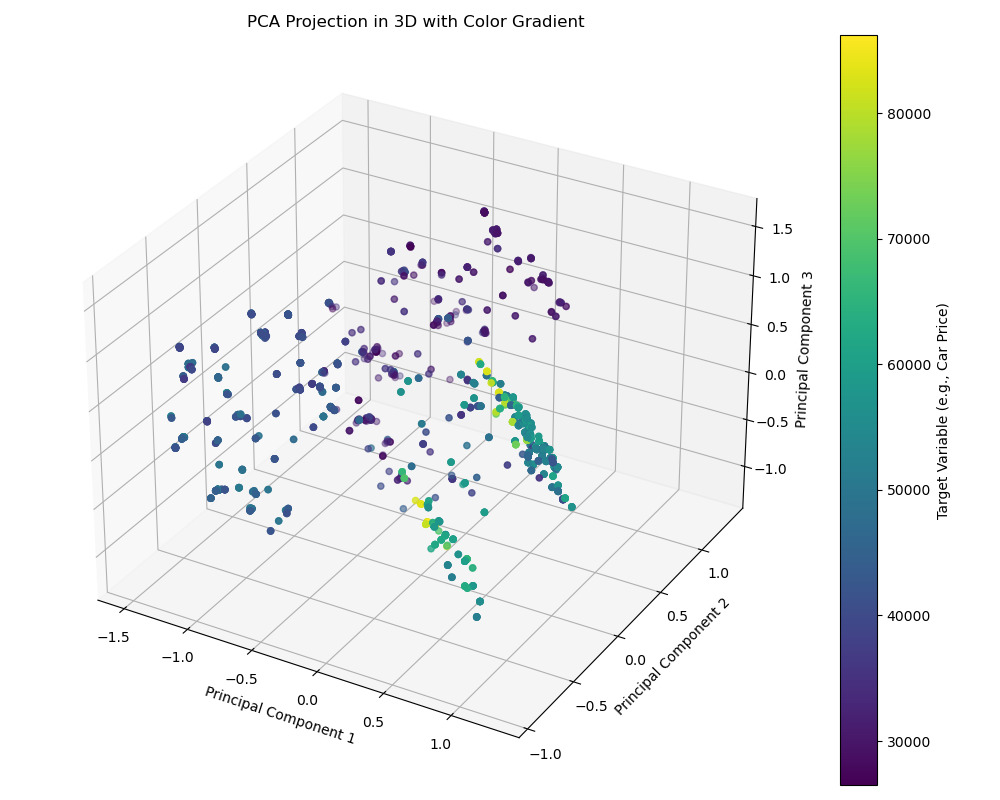

In [15]:
%matplotlib widget
k = 3
matrix_w = np.hstack([eig_pairs[i][1].reshape(n_features, 1) for i in range(k)])
# Проекция данных на новое пространство признаков
X_pca = np.real(X_array.dot(matrix_w))
# Визуализация результата в 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=Y, cmap='viridis', marker='o')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(scatter, label='Target Variable (e.g., Car Price)')
plt.title('PCA Projection in 3D with Color Gradient')
plt.tight_layout()
plt.show()